# Testing Images Optimal Transport Benchmarks (unequal dims)
Evaluation of the OTM algorithm in the **equal dimensions** "Early" [Continuous Wasserstein-2 Benchmark](https://github.com/iamalexkorotin/Wasserstein2Benchmark) for images.

**WARNING!** This notebook should be tested inside ```Wasserstein2Benchmark/notebooks``` folder! 

**GPU-only implementation.**

In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import gc

import pandas as pd

from sklearn.decomposition import PCA
from src.tools import unfreeze, freeze
from src.resnet2 import ResNet_G, weights_init_G, ResNet_D
from src.icnn import View
from torch import nn
import src.map_benchmark as mbm
from src.unet import UNet

from tqdm import tqdm
from IPython.display import clear_output

## Changable Config

In [2]:
BATCH_SIZE = 64
GPU_DEVICE = 1

K_G = 5
K_psi = 1

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000000); np.random.seed(0x000000)

## Benchmark Loading

In [3]:
benchmark = mbm.CelebA64Benchmark(which='Early', batch_size=BATCH_SIZE)

# Swap output and input
X_sampler = benchmark.output_sampler
Y_sampler = benchmark.input_sampler

## Initializing networks

In [4]:
# Generator
T = nn.Sequential(
    View(3,64,64),
    UNet(n_channels=3, n_classes=3),
    View(64*64*3)
)
T = T.cuda()

In [5]:
# Potential
psi = nn.Sequential(
    View(3, 64, 64),
    ResNet_D(),
)

def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

psi.apply(weights_init_D)
psi = psi.cuda()

## Code for plotting

In [6]:
# Fixed samples to plot
Y_fixed = Y_sampler.sample(10).requires_grad_(True)
X_fixed = benchmark.output_sampler.potential.push(Y_fixed).detach()
Y_fixed.requires_grad_(False)
pass

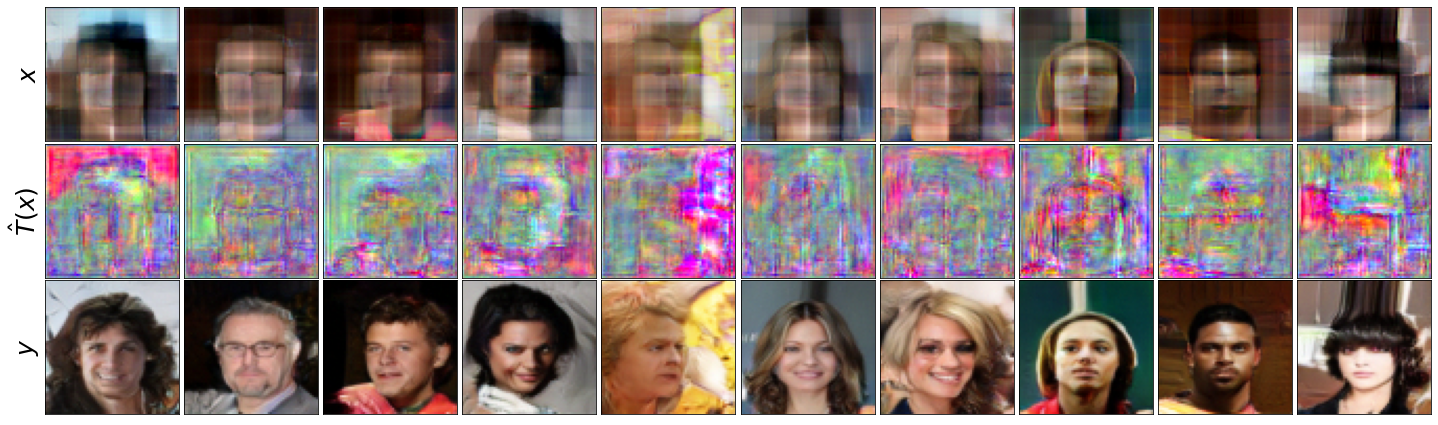

In [7]:
def plot(X, Y, T):
    fig, axes = plt.subplots(3, len(X), figsize=(len(X)*2+.1, 3*2))
    T_X = T(X).reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
    X_in = X.reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
    Y_out = Y.reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
    for i in range(len(X)):
        axes[0,i].imshow(X_in[i].permute(1, 2, 0))
        axes[1,i].imshow(T_X[i].permute(1, 2, 0))
        axes[2,i].imshow(Y_out[i].permute(1, 2, 0))
        
    for i, ax in enumerate(axes.flatten()):
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
    axes[0, 0].set_ylabel(r'$x$', fontsize=25)
    axes[1, 0].set_ylabel(r'$\hat{T}(x)$', fontsize=25)
    axes[2, 0].set_ylabel(r'$y$', fontsize=25)
    
    fig.tight_layout(h_pad=0.01, w_pad=0.01)
    gc.collect(); torch.cuda.empty_cache()
    return fig, axes

fig, axes = plot(X_fixed, Y_fixed, T)

## Training Loss

In [8]:
import torch.autograd as autograd

def W2Loss(psi, T, X, Y):
    T_X = T(X)
    return (X * T_X).mean(dim=1).mean() - psi(T_X).mean() + psi(Y).mean()

## Main Training

In [9]:
T_opt = torch.optim.Adam(T.parameters(), lr = 1e-4, weight_decay=1e-10)
psi_opt = torch.optim.Adam(psi.parameters(), lr = 1e-4, weight_decay=1e-10)

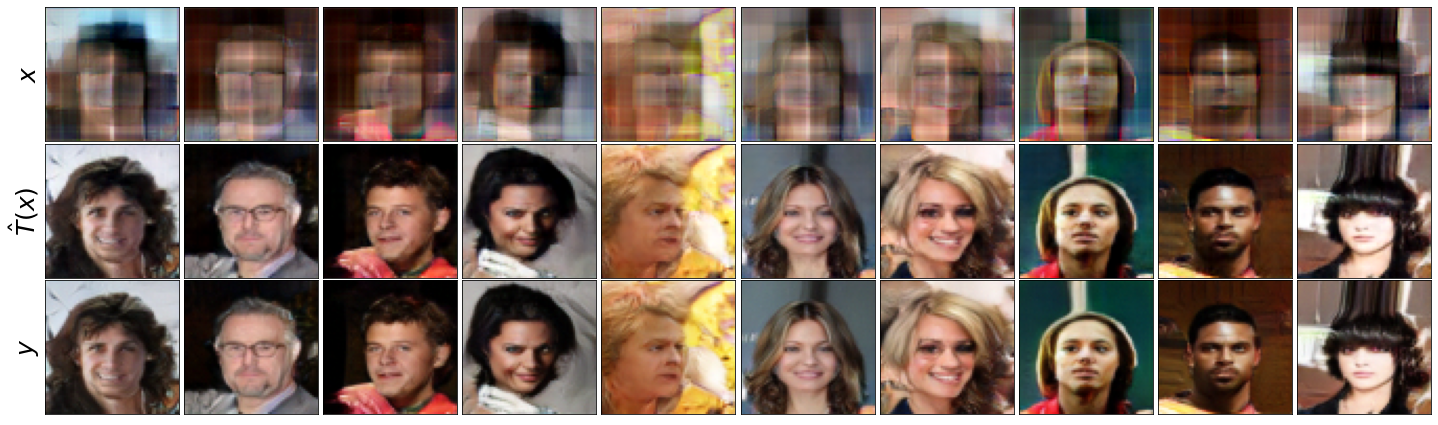

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [15:12:19<00:00,  2.19s/it]


In [10]:
for it in tqdm(range(25000)):
    ##########################################################
    ## Outer minimization loop
    ##########################################################   
    freeze(T); unfreeze(psi)
    for k_psi in range(K_psi):
        X, Y = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
        psi_loss = W2Loss(psi, T, X, Y)
        psi_opt.zero_grad(); psi_loss.backward(); psi_opt.step()
    del psi_loss
    gc.collect(); torch.cuda.empty_cache()

    ##########################################################
    ## Inner maximization loop
    ##########################################################
    freeze(psi); unfreeze(T)
    for k_G in range(K_G):
        X, Y = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
        T_loss = -W2Loss(psi, T, X, Y) 
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()
    del T_loss
    gc.collect(); torch.cuda.empty_cache()
        
    if it % 50 == 0:
        clear_output(wait=True); freeze(T)
        fig, axes = plot(X_fixed, Y_fixed, T); plt.show()

In [11]:
freeze(T)
L2s = []
for batch_idx in tqdm(range(2**14 // 64)):
    Y = Y_sampler.sample(10).requires_grad_(True)
    X = benchmark.output_sampler.potential.push(Y).detach()
    Y.requires_grad_(False)
    T_X = T(X).detach()
    L2s.append(((Y-T_X) ** 2).sum(dim=1).mean().item())
    
print('L2-UVP =', 100 * np.mean(L2s) / Y_sampler.var)

100%|███████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 32.96it/s]

L2-UVP = 1.3289709986510279
